In [2]:
import pandas as pd
import requests 
import sqlite3
import matplotlib.pyplot as plt

In [3]:
url = "https://api.worldbank.org/v2/country/all/indicator/EG.USE.PCAP.KG.OE?format=json&per_page=20000"
data = requests.get(url).json()[1]
df = pd.DataFrame(data)

In [7]:
df = df[['country', 'year', 'energy_use']]
df.rename(columns={'date': 'year'}, inplace=True)
df.rename(columns={'value': 'energy_use'}, inplace=True)
df['year'] = df['year'].astype(int)

# df.columns = ['country', 'year', 'energy_use']
df = df[df['year'].between(2014, 2024)]
df.dropna(inplace=True)
df.head()

,country,year,energy_use
2,"{'id': 'ZH', 'value': 'Africa Eastern and Sout...",2022,562.060699
3,"{'id': 'ZH', 'value': 'Africa Eastern and Sout...",2021,579.816693
4,"{'id': 'ZH', 'value': 'Africa Eastern and Sout...",2020,566.960723
5,"{'id': 'ZH', 'value': 'Africa Eastern and Sout...",2019,587.648036
6,"{'id': 'ZH', 'value': 'Africa Eastern and Sout...",2018,585.044145


In [10]:
df['country_code'] = df['country'].apply(lambda x: x['id'])
df['country_name'] = df['country'].apply(lambda x: x['value'])
df = df.drop(columns=['country'])
df.head()

,year,energy_use,country_code,country_name
2,2022,562.060699,ZH,Africa Eastern and Southern
3,2021,579.816693,ZH,Africa Eastern and Southern
4,2020,566.960723,ZH,Africa Eastern and Southern
5,2019,587.648036,ZH,Africa Eastern and Southern
6,2018,585.044145,ZH,Africa Eastern and Southern


In [11]:
conn = sqlite3.connect('energy_data.db')
df.to_sql('energy_metrics', conn, if_exists='replace', index=False)

1829

In [13]:
query = """
SELECT country_code, country_name, year, AVG(energy_use) AS avg_energy_use
FROM energy_metrics
GROUP BY country_code, year
ORDER BY avg_energy_use DESC
"""
pd.read_sql(query, conn)

,country_code,country_name,year,avg_energy_use
0,IS,Iceland,2014,17947.038227
1,QA,Qatar,2014,17814.543110
2,IS,Iceland,2018,17346.750273
3,QA,Qatar,2021,17100.750612
4,IS,Iceland,2015,16910.721233
...,...,...,...,...
1824,SS,South Sudan,2016,70.832689
1825,SS,South Sudan,2017,69.999725
1826,SS,South Sudan,2022,69.043365
1827,YE,"Yemen, Rep.",2022,68.949535


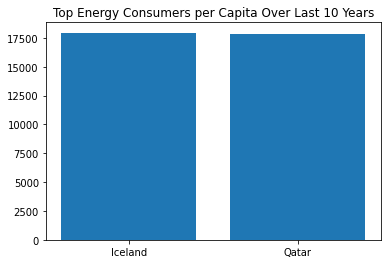

In [14]:
top = pd.read_sql(query, conn).head(10)

plt.figure()
plt.bar(top['country_name'], top['avg_energy_use'])
plt.title('Top Energy Consumers per Capita Over Last 10 Years')
plt.show()

In [15]:
df['year'] = df['year'].astype(int)
df['energy_use'] = df['energy_use'].astype(float)
df['yoy_change'] = df.groupby('country_name')['energy_use'].diff()
df['yoy_growth_pct'] = df.groupby('country_name')['energy_use'].pct_change() * 100

In [16]:
india = df[df['country_name'] == 'India']

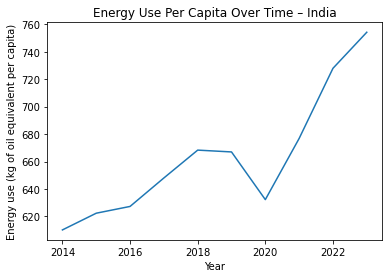

In [17]:
plt.figure()
plt.plot(india['year'], india['energy_use'])
plt.xlabel('Year')
plt.ylabel('Energy use (kg of oil equivalent per capita)')
plt.title('Energy Use Per Capita Over Time – India')
plt.show()

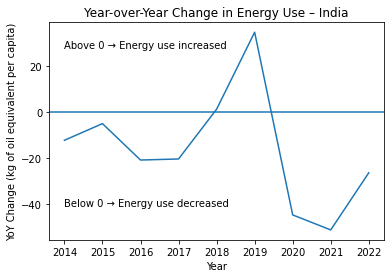

In [18]:
df.head()
country_df = df[df['country_name'] == 'India']

plt.figure()
plt.plot(country_df['year'], country_df['yoy_change'])
plt.axhline(0)

plt.text(country_df['year'].min(), 
         country_df['yoy_change'].max() * 0.8,
         'Above 0 → Energy use increased')

plt.text(country_df['year'].min(), 
         country_df['yoy_change'].min() * 0.8,
         'Below 0 → Energy use decreased')

plt.xlabel('Year')
plt.ylabel('YoY Change (kg of oil equivalent per capita)')
plt.title('Year-over-Year Change in Energy Use – India')
plt.show()

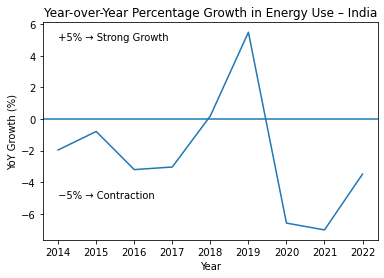

In [207]:
plt.figure()
plt.plot(country_df['year'], country_df['yoy_growth_pct'])
plt.axhline(0)

plt.text(country_df['year'].min(), 5, '+5% → Strong Growth')
plt.text(country_df['year'].min(), -5, '−5% → Contraction')

plt.xlabel('Year')
plt.ylabel('YoY Growth (%)')
plt.title('Year-over-Year Percentage Growth in Energy Use – India')
plt.show()